# Introduction
The most prized individual accolade for a player in the NBA is the Most Valuable Player award. The award is decided by a panel of sportswriters and broadcasters. Winning this award signifies that the player was percieved as the most important player in the NBA. There have been 67 (1955-2023) different players who have won this award.
<img src="https://library.sportingnews.com/2021-08/michael-jordan_yzt70lkmipqq19lqklwtwpeu3.png"  width="900" height="600" class="center">


What then, do those winners have in common? 

Given player statistics, can we accurately predict what player will win the MVP award in a given year?

# Why should you care?

- This is bigger than basketball. You don't need be a basketball fan to appreciate this problem.
- We will cover techniques that are useful across multiple problem domains such as web scraping, modeling, and defining an API.


# Data Source and Description

The data in this dataset was scraped from www.basketball-reference.com, a website dedicated to tracking basketball statistics. Scraping was done using the beautifulSoup python package. Our dataset contains data from 1973 - 2018. <img src="https://statisticaloddsandends.files.wordpress.com/2018/12/basketball-reference.png?w=584&h=415" class="center">




In [92]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import joblib

#models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier as ABC

#feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

#scalers
from sklearn.preprocessing import StandardScaler

#score function
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [93]:
stats_df = pd.read_csv('../data/NBA_Stats_MVP.csv')
stats_df

,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,TRB,AST,STL,BLK,TOV,PF,PTS,is_allstar,Name,was_mvp
0,1974.0,C,27.0,HOU,79.0,NaN,2459.0,15.9,0.516,NaN,...,923.0,166.0,80.0,104.0,NaN,227.0,865.0,0,Zaid Abdul-Aziz,0
1,1974.0,C,26.0,MIL,81.0,NaN,3548.0,24.4,0.564,NaN,...,1178.0,386.0,112.0,283.0,NaN,238.0,2191.0,1,Kareem Abdul-Jabbar,1
2,1974.0,SF,26.0,DET,74.0,NaN,2298.0,10.9,0.457,NaN,...,448.0,141.0,110.0,12.0,NaN,242.0,759.0,0,Don Adams,0
3,1974.0,PG,27.0,CHI,55.0,NaN,618.0,10.0,0.447,NaN,...,69.0,56.0,36.0,1.0,NaN,63.0,182.0,0,Rick Adelman,0
4,1974.0,PG,26.0,MIL,72.0,NaN,2388.0,18.8,0.536,NaN,...,291.0,374.0,137.0,22.0,NaN,215.0,1268.0,0,Lucius Allen,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,...,405.0,99.0,62.0,58.0,65.0,189.0,639.0,0,Cody Zeller,0
20793,2017.0,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,...,124.0,42.0,7.0,21.0,20.0,61.0,178.0,0,Tyler Zeller,0
20794,2017.0,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,...,35.0,4.0,2.0,5.0,3.0,17.0,23.0,0,Stephen Zimmerman,0
20795,2017.0,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,...,125.0,36.0,15.0,16.0,40.0,78.0,240.0,0,Paul Zipser,0


In [94]:
stats_df.fillna(0, inplace = True)

In [95]:
def per_game(stats_df, cols):
    """
    returns a new data frame version of stats_df, where a per game average is added for each column name 
    contained within cols
    
    :param stats_df: A dataframe containing basketball stats.
    :param cols: A list of column names where per game averages are desired.
    :return: A new dataframe containing per game averages for stats contained within cols. 
    :rtype: Dataframe
    """
    new_df = stats_df.copy()
    for col in cols:
        new_df[col + 'PG'] = stats_df[col]/stats_df['G']
    return new_df

In [96]:
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
stats_df = per_game(stats_df, per_game_cols)

In [97]:
stats_df

,Year,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,...,TRBPG,STLPG,BLKPG,TOVPG,PFPG,FGAPG,FGPG,FTPG,FTAPG,MPPG
0,1974.0,C,27.0,HOU,79.0,0.0,2459.0,15.9,0.516,0.000,...,11.683544,1.012658,1.316456,0.000000,2.873418,9.265823,4.253165,2.443038,3.037975,31.126582
1,1974.0,C,26.0,MIL,81.0,0.0,3548.0,24.4,0.564,0.000,...,14.543210,1.382716,3.493827,0.000000,2.938272,21.716049,11.703704,3.641975,5.185185,43.802469
2,1974.0,SF,26.0,DET,74.0,0.0,2298.0,10.9,0.457,0.000,...,6.054054,1.486486,0.162162,0.000000,3.270270,10.027027,4.094595,2.067568,2.716216,31.054054
3,1974.0,PG,27.0,CHI,55.0,0.0,618.0,10.0,0.447,0.000,...,1.254545,0.654545,0.018182,0.000000,1.145455,3.090909,1.163636,0.981818,1.381818,11.236364
4,1974.0,PG,26.0,MIL,72.0,0.0,2388.0,18.8,0.536,0.000,...,4.041667,1.902778,0.305556,0.000000,2.986111,14.750000,7.305556,3.000000,3.805556,33.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,PF,24.0,CHO,62.0,58.0,1725.0,16.7,0.604,0.002,...,6.532258,1.000000,0.935484,1.048387,3.048387,7.145161,4.080645,2.145161,3.161290,27.822581
20793,2017.0,C,27.0,BOS,51.0,5.0,525.0,13.0,0.508,0.006,...,2.431373,0.137255,0.411765,0.392157,1.196078,3.098039,1.529412,0.431373,0.764706,10.294118
20794,2017.0,C,20.0,ORL,19.0,0.0,108.0,7.3,0.346,0.000,...,1.842105,0.105263,0.263158,0.157895,0.894737,1.631579,0.526316,0.157895,0.263158,5.684211
20795,2017.0,SF,22.0,CHI,44.0,18.0,843.0,6.9,0.503,0.448,...,2.840909,0.340909,0.363636,0.909091,1.772727,5.022727,2.000000,0.704545,0.909091,19.159091


# Methods

## Supervised Learning

Have a collection of labeled examples $\{(x_n, y_n)\}^N_{n=1}$ (i.e. the dataset) with $x_n \in X$, $y_n \in Y$


$x_n$ : feature vector

$y_n$ : label associated with specific entry

$X$ : Feature Space

$Y$: Label Space

Goal: To find a mapping $f : X \rightarrow Y$



## Classification vs Regression

- Regression involves predicting a continuous value (i.e. a numeric value). $f : X \rightarrow 	\mathbb{R}$. Inputs can be anything, outputs are real numbers

- Classification involves predicting a label for an observation from a discrete finite set of class labels. $f : X \rightarrow \{0,1,\dots, C\} \subset  	\mathbb{N_0}$. Inputs can be anything. Outputs are class indicies (e.g. [cat, dog], [mvp, not mvp], [positive, negative]).

<img src="https://lh4.googleusercontent.com/K17BRCQTR5hHU-qOthrs9KIQa4DLAWJh5jeXkyn6NZRQfimHnCAadWbw3EaZPZl1bit2IBQPeBv1CZURiyFYkIDPH1Z3Pb0O_qkeS9av7vrEtQLpMLWdtDJ7YNlRki8CoAsY8bmn
" class="center">

## In Context
- Regression: Could be done by predicting the number of MVP votes a player recieves.

- Classification: Could be done by classifying each player as 'MVP' (true) and 'Not MVP' (false). 

## Scoring Models


* Metrics:
    - **Accuracy**: The fraction of predictions our model got right. For this problem, accuracy is a **highly misleading** metric.
    - **True positive**: a player was predicted as the MVP and actually won the MVP.
    - **False positive**: a player was predicted as the MVP but did not win the MVP.
    - **True negative**: a player was predicted as a non-MVP and was not the MVP.
    - **False negative**: a player was predicted as a non-MVP but actually won the MVP.


##  Why is accuracy so misleading?

This is due to the fact that there are very few players who win the MVP, any model can simply guess non-MVP for every player and achieve high accuracy (99%).

# Defining X and Y

In [98]:
stats_df = stats_df.drop(columns = ['Pos', 'Name', 'Tm'])
#stats_df = stats_df.drop(columns = ['Pos', 'Name', 'Tm', 'Year'])
X = stats_df.drop(columns = ['was_mvp'])
y = stats_df['was_mvp']

In [99]:
stats_df

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,TRBPG,STLPG,BLKPG,TOVPG,PFPG,FGAPG,FGPG,FTPG,FTAPG,MPPG
0,1974.0,27.0,79.0,0.0,2459.0,15.9,0.516,0.000,0.328,11.4,...,11.683544,1.012658,1.316456,0.000000,2.873418,9.265823,4.253165,2.443038,3.037975,31.126582
1,1974.0,26.0,81.0,0.0,3548.0,24.4,0.564,0.000,0.239,8.8,...,14.543210,1.382716,3.493827,0.000000,2.938272,21.716049,11.703704,3.641975,5.185185,43.802469
2,1974.0,26.0,74.0,0.0,2298.0,10.9,0.457,0.000,0.271,6.0,...,6.054054,1.486486,0.162162,0.000000,3.270270,10.027027,4.094595,2.067568,2.716216,31.054054
3,1974.0,27.0,55.0,0.0,618.0,10.0,0.447,0.000,0.447,2.6,...,1.254545,0.654545,0.018182,0.000000,1.145455,3.090909,1.163636,0.981818,1.381818,11.236364
4,1974.0,26.0,72.0,0.0,2388.0,18.8,0.536,0.000,0.258,4.1,...,4.041667,1.902778,0.305556,0.000000,2.986111,14.750000,7.305556,3.000000,3.805556,33.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20792,2017.0,24.0,62.0,58.0,1725.0,16.7,0.604,0.002,0.442,8.6,...,6.532258,1.000000,0.935484,1.048387,3.048387,7.145161,4.080645,2.145161,3.161290,27.822581
20793,2017.0,27.0,51.0,5.0,525.0,13.0,0.508,0.006,0.247,9.2,...,2.431373,0.137255,0.411765,0.392157,1.196078,3.098039,1.529412,0.431373,0.764706,10.294118
20794,2017.0,20.0,19.0,0.0,108.0,7.3,0.346,0.000,0.161,10.8,...,1.842105,0.105263,0.263158,0.157895,0.894737,1.631579,0.526316,0.157895,0.263158,5.684211
20795,2017.0,22.0,44.0,18.0,843.0,6.9,0.503,0.448,0.181,1.9,...,2.840909,0.340909,0.363636,0.909091,1.772727,5.022727,2.000000,0.704545,0.909091,19.159091


# Splitting The Data
- Splitting the data into training and testing sets is crucial for most models. 
- One of the most common methods involves randomly splitting the data.

## Why is a random split not ideal?


- 20752 non MVP players, and 45 MVP players.
- One winner every year.
- A true random split could lead to there being few to, 0 MVP players in either training or testing set.

In [100]:
stats_df['Year'].unique()
train_years = np.random.choice(a=stats_df['Year'].unique(), size=round(len(stats_df['Year'].unique()) * .7))
train_years

array([1976., 2014., 2016., 1976., 1977., 2010., 2007., 1985., 1977.,
       1983., 2006., 2017., 2014., 1994., 2016., 1993., 2009., 1984.,
       1988., 1993., 1997., 2014., 1979., 1997., 1993., 1990., 1982.,
       1981., 1985., 1982., 2004.])

In [101]:
train = stats_df[stats_df['Year'].isin(train_years)]
test = stats_df[~stats_df['Year'].isin(train_years)]

In [102]:
train = train.drop(columns = ['Year'])
test = test.drop(columns = ['Year'])

In [103]:
X_train = train.drop(columns = ['was_mvp'])
y_train = train['was_mvp']

In [104]:
X_test = test.drop(columns = ['was_mvp'])
y_test = test['was_mvp']

# Modeling

- There are many approaches to modeling, this is my favorite method. 


## Dictionaries

- Dictionaries are used to store data values in key:value pairs.

In [105]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

## Dictionary of Models

In [106]:
def score_models(X_train, y_train, X_test, y_test):
    models = {'RandomForestClassifier':{'model':RFC()}, 
        'KNeighborsClassifier':{'model':KNeighborsClassifier()},
         'GradientBoostingClassifier': {'model':GBC()},
         'logistic': {'model':LogisticRegression(max_iter=10000)},
         'adaboost': {'model':ABC()},
         'ScaledRandomForestClassifier':{'model':make_pipeline(StandardScaler(), RFC())}, 
        'ScaledKNeighborsClassifier':{'model':make_pipeline(StandardScaler(), KNeighborsClassifier())},
         'ScaledGradientBoostingClassifier': {'model':make_pipeline(StandardScaler(), GBC())},
         'Scaledlogistic': {'model':make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))},
         'Scaledadaboost': {'model':make_pipeline(StandardScaler(), ABC())}}
    for model_name in models:
        print(model_name)
        model = models[model_name]['model']
        fitted_model = model.fit(X_train, y_train)
        models[model_name]['train_f1_score'] = f1_score(y_train, fitted_model.predict(X_train), average='macro')
        models[model_name]['train_accuracy_score'] = accuracy_score(y_train, fitted_model.predict(X_train))
        models[model_name]['test_f1_score'] = f1_score(y_test, fitted_model.predict(X_test), average='macro')
        models[model_name]['test_accuracy_score'] = accuracy_score(y_test, fitted_model.predict(X_test))
        models[model_name]['fitted_model'] = fitted_model
        models[model_name]['y_train_pred'] = fitted_model.predict(X_train)
        models[model_name]['y_test_pred'] = fitted_model.predict(X_test) 
        tn, fp, fn, tp = confusion_matrix(y_test, models[model_name]['y_test_pred']).ravel()
        models[model_name]['tp'] = tp
        models[model_name]['fp'] = fp
        models[model_name]['fn'] = fn
        models[model_name]['tn'] = tn
        cm = confusion_matrix(y_test, models[model_name]['y_test_pred'])
        print(cm)
        
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=20);  #annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(['Not MVP', 'MVP']); ax.yaxis.set_ticklabels(['Not MVP', 'MVP'])
        plt.show()
    return models


RandomForestClassifier
[[10969     1]
 [   19     4]]


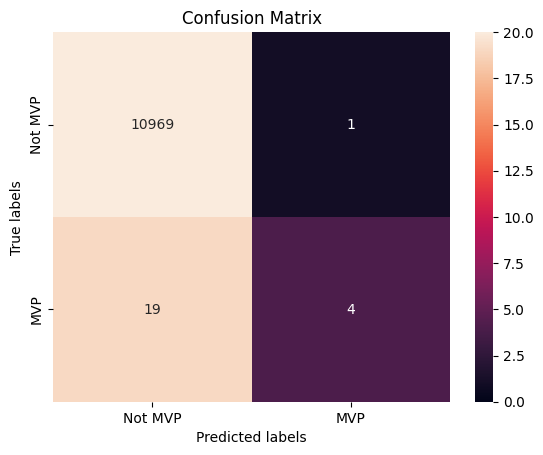

KNeighborsClassifier
[[10970     0]
 [   22     1]]


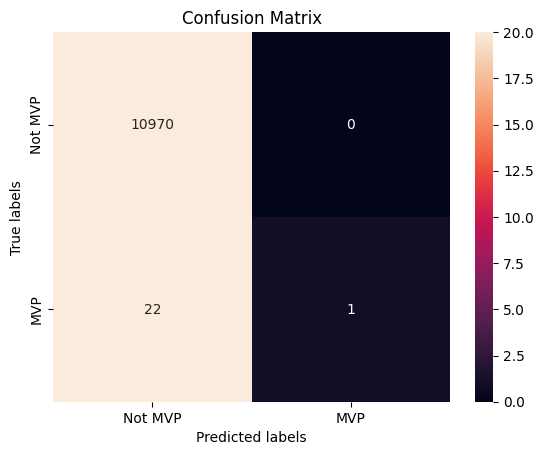

GradientBoostingClassifier
[[10960    10]
 [   16     7]]


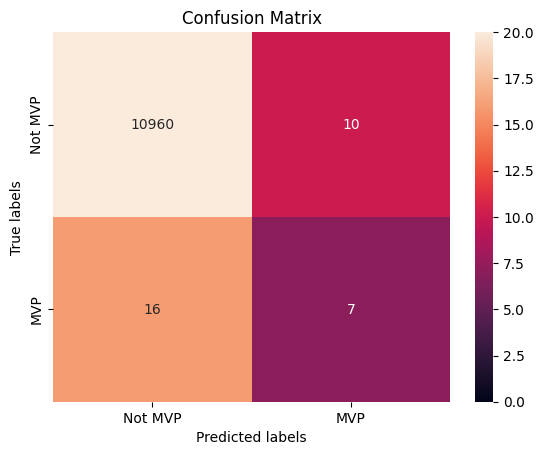

logistic
[[10957    13]
 [    9    14]]


/home/courier/Documents/NBAMVPPredictor/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


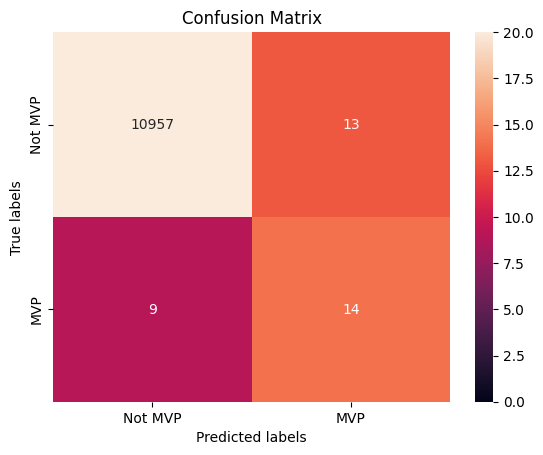

adaboost
[[10962     8]
 [   17     6]]


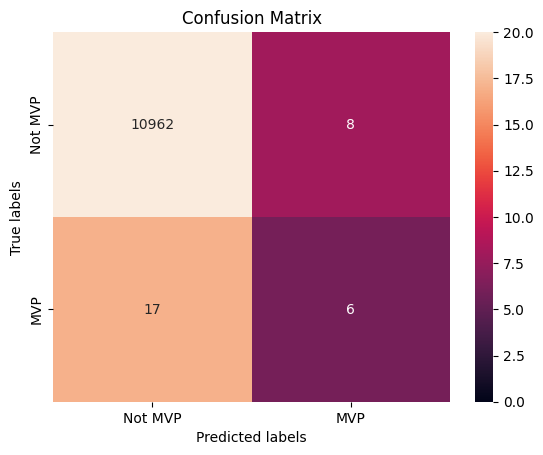

ScaledRandomForestClassifier
[[10969     1]
 [   19     4]]


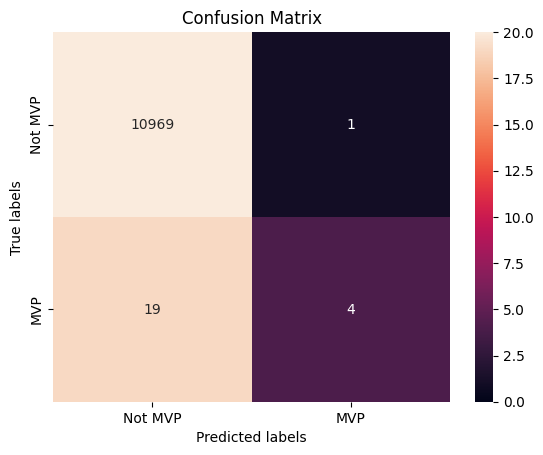

ScaledKNeighborsClassifier
[[10966     4]
 [   22     1]]


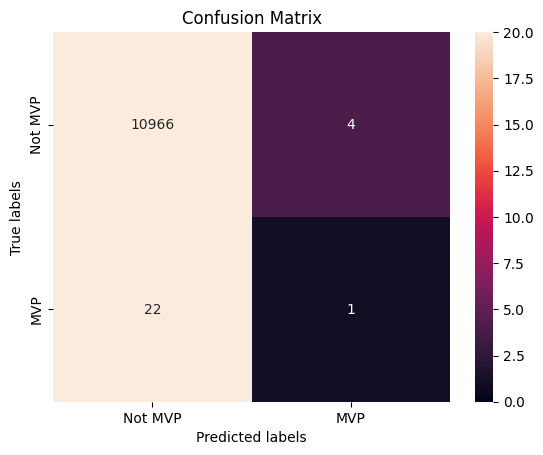

ScaledGradientBoostingClassifier
[[10961     9]
 [   17     6]]


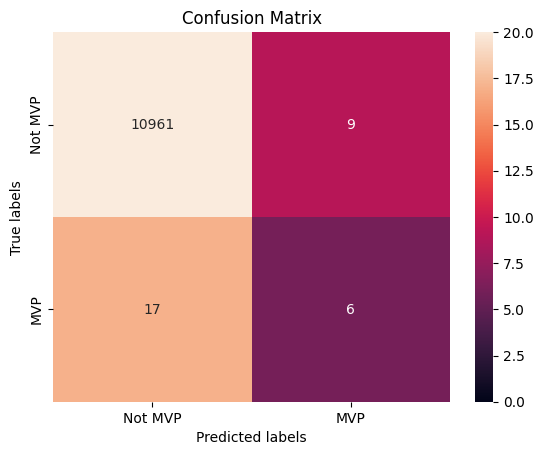

Scaledlogistic
[[10963     7]
 [   13    10]]


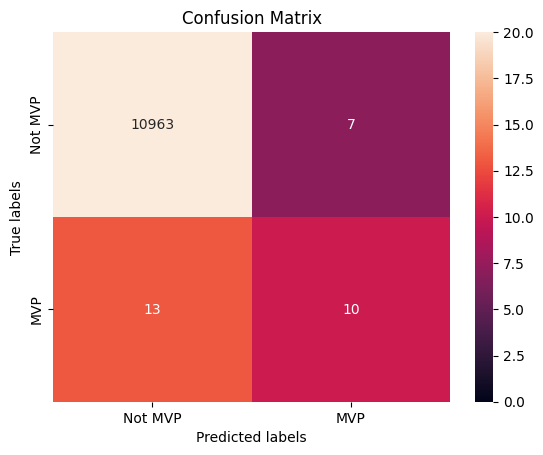

Scaledadaboost
[[10962     8]
 [   17     6]]


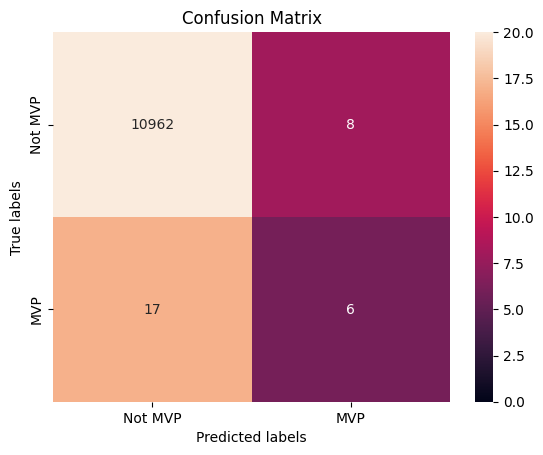

In [107]:
models = score_models(X_train, y_train, X_test, y_test)

In [108]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
#model = models['ScaledGradientBoostingClassifier']['fitted_model']
selector = RFECV(DecisionTreeClassifier(), step=1, cv=5)
selector = selector.fit(X_train, y_train)
selector.support_
selector.ranking_

array([54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 43, 42, 41, 40, 39, 38,  3,
        1,  1,  9,  8,  7,  1,  1, 19, 23, 26, 28, 31,  1, 33, 35, 25, 36,
       13, 44, 15, 17, 37, 21, 34, 32, 30, 24, 22, 20, 18, 16, 14,  1,  6,
        1, 27, 29,  5,  2, 10, 11, 12,  4,  1])

In [109]:
to_drop = []
for i in range(X_train.shape[1]):
    if selector.support_[i] == False:
        to_drop.append(X_train.iloc[:, i].name)
        print('Column: %s, Selected %s, Rank: %.3f' % (X_train.iloc[:, i].name, selector.support_[i], selector.ranking_[i]))

Column: Age, Selected False, Rank: 54.000
Column: G, Selected False, Rank: 53.000
Column: GS, Selected False, Rank: 52.000
Column: MP, Selected False, Rank: 51.000
Column: PER, Selected False, Rank: 50.000
Column: TS%, Selected False, Rank: 49.000
Column: 3PAr, Selected False, Rank: 48.000
Column: FTr, Selected False, Rank: 47.000
Column: ORB%, Selected False, Rank: 46.000
Column: DRB%, Selected False, Rank: 45.000
Column: TRB%, Selected False, Rank: 43.000
Column: AST%, Selected False, Rank: 42.000
Column: STL%, Selected False, Rank: 41.000
Column: BLK%, Selected False, Rank: 40.000
Column: TOV%, Selected False, Rank: 39.000
Column: USG%, Selected False, Rank: 38.000
Column: OWS, Selected False, Rank: 3.000
Column: WS/48, Selected False, Rank: 9.000
Column: OBPM, Selected False, Rank: 8.000
Column: DBPM, Selected False, Rank: 7.000
Column: FG, Selected False, Rank: 19.000
Column: FGA, Selected False, Rank: 23.000
Column: FG%, Selected False, Rank: 26.000
Column: 3P, Selected False, Ra

In [110]:
for i in range(X_train.shape[1]):
    if selector.support_[i] == True:
        print('Column: %s, Selected %s, Rank: %.3f' % (X_train.iloc[:, i].name, selector.support_[i], selector.ranking_[i]))

Column: DWS, Selected True, Rank: 1.000
Column: WS, Selected True, Rank: 1.000
Column: BPM, Selected True, Rank: 1.000
Column: VORP, Selected True, Rank: 1.000
Column: 3P%, Selected True, Rank: 1.000
Column: ORBPG, Selected True, Rank: 1.000
Column: TRBPG, Selected True, Rank: 1.000
Column: MPPG, Selected True, Rank: 1.000


In [111]:
X_selected_train = train.drop(columns = to_drop + ['was_mvp'])
y_selected_train = train['was_mvp']

In [112]:
X_selected_test = test.drop(columns = to_drop + ['was_mvp'])
y_selected_test = test['was_mvp']

## Feature Selection

- Each tree of a random forest can calculate the importance of a feature according to its ability to increase the "pureness" of the leaves.
- The higher the increment in leaves purity, the higher the importance of the feature.

<AxesSubplot: ylabel='cols'>

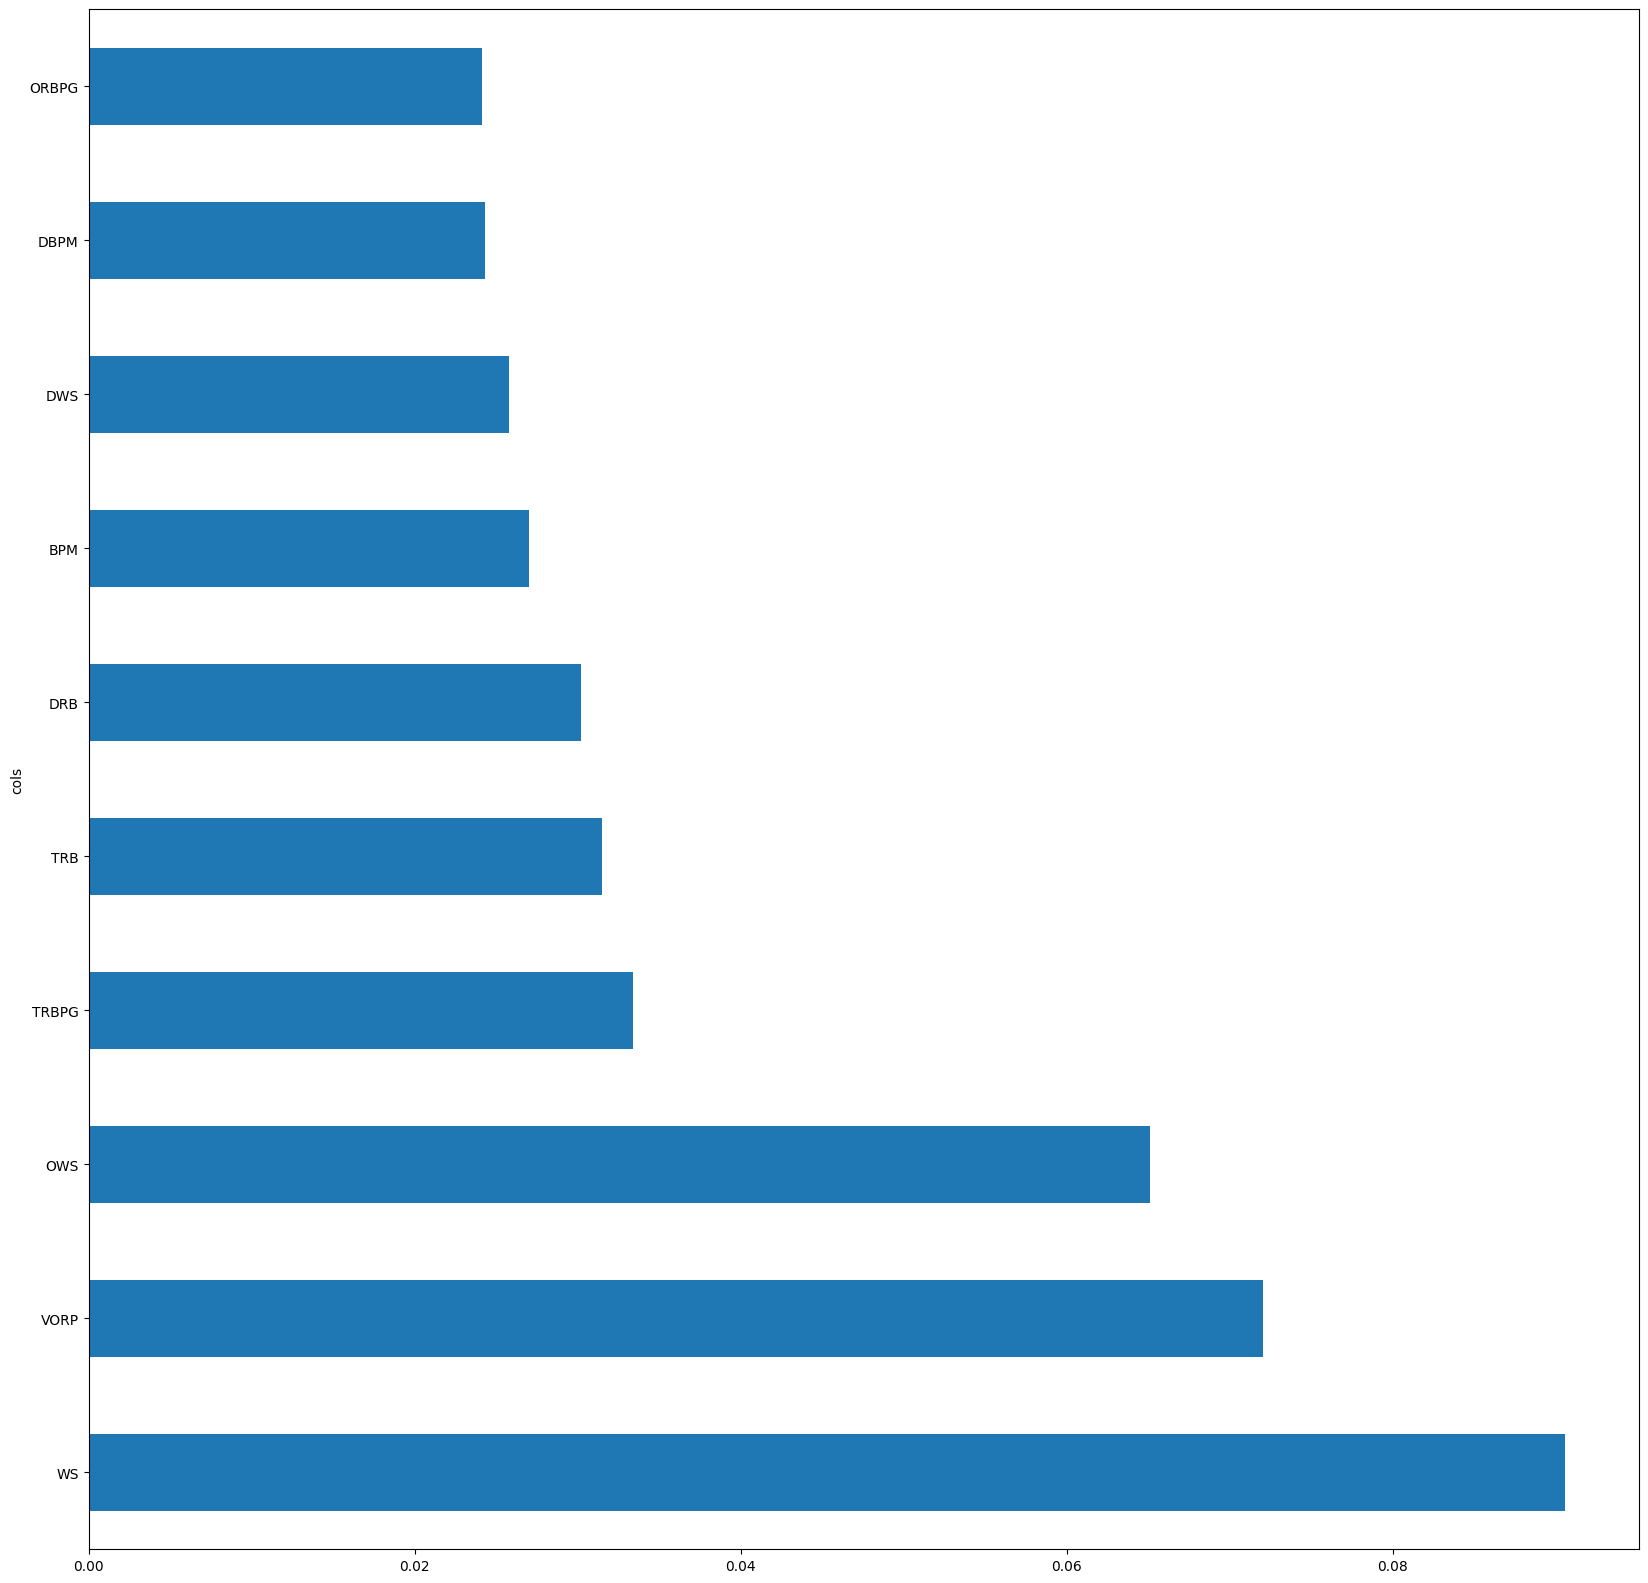

In [145]:
def rf_feat_importance(m, df):
    """
    This function will show us the feature importance according to a random forest model.
    
    :param m: The random forest model.
    :param df: The dataframe.
    :return: A dataframe of feature importances.
    """
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    """
    Function used for plotting feature importances from a random forest.
    :param fi: A dataframe containing features and their importance.
    :return: A plot of the feature importances. 
    """
    return fi.plot('cols', 'imp', 'barh', figsize=(20,20), legend=False)

plot_fi(rf_feat_importance(models['RandomForestClassifier']['model'], X_train)[:10])

RandomForestClassifier
[[10968     2]
 [   18     5]]


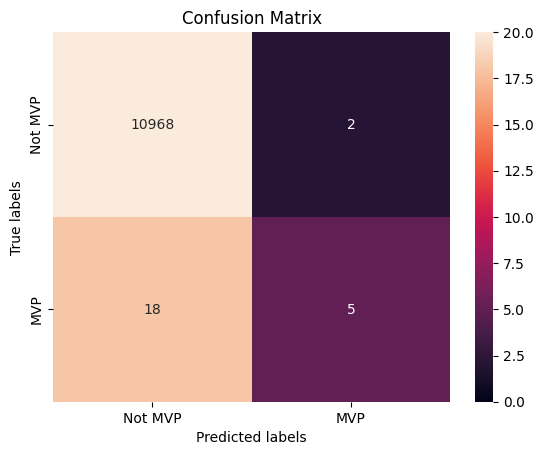

KNeighborsClassifier
[[10967     3]
 [   19     4]]


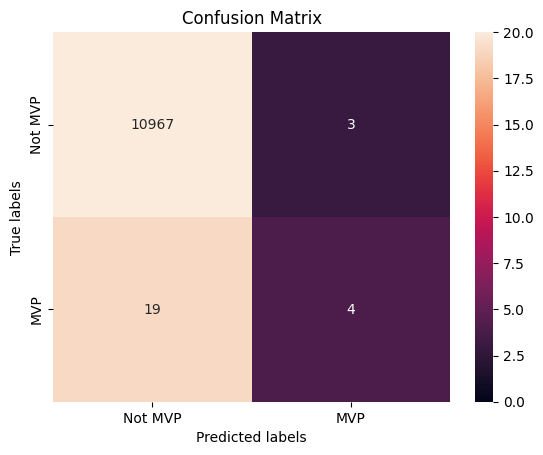

GradientBoostingClassifier
[[10957    13]
 [   16     7]]


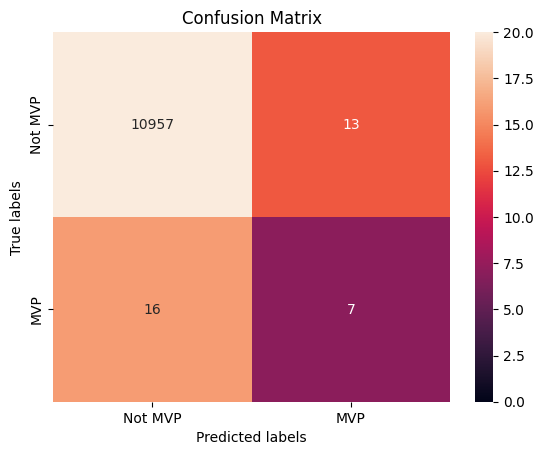

logistic
[[10964     6]
 [   15     8]]


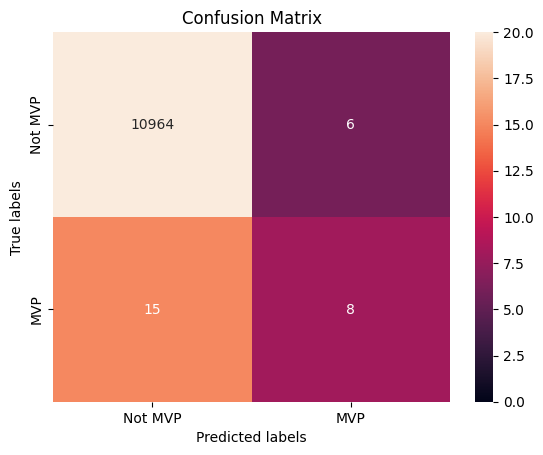

adaboost
[[10962     8]
 [   18     5]]


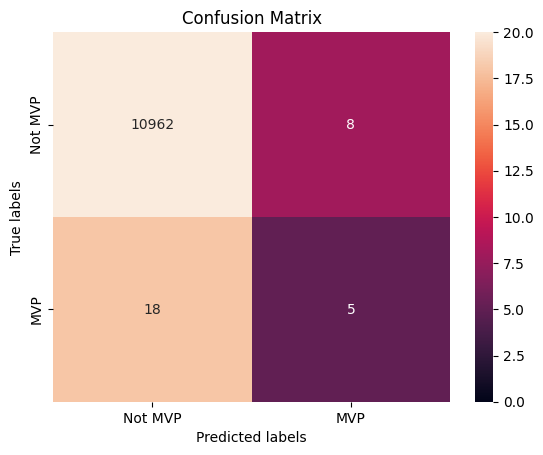

ScaledRandomForestClassifier
[[10966     4]
 [   18     5]]


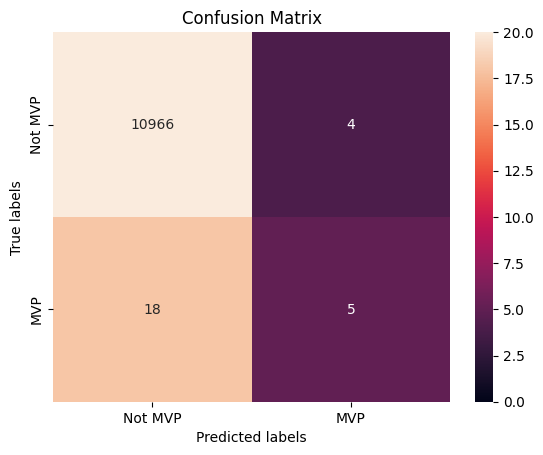

ScaledKNeighborsClassifier
[[10968     2]
 [   20     3]]


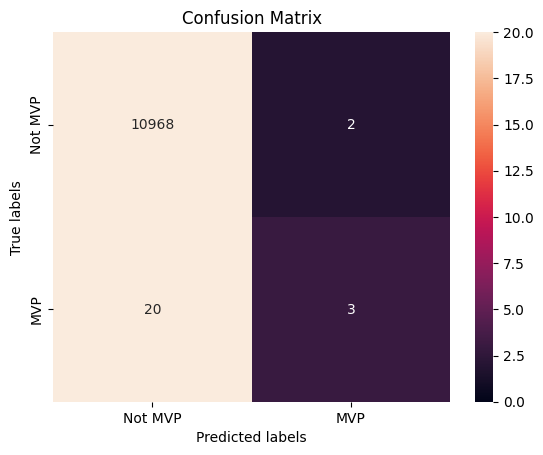

ScaledGradientBoostingClassifier
[[10957    13]
 [   16     7]]


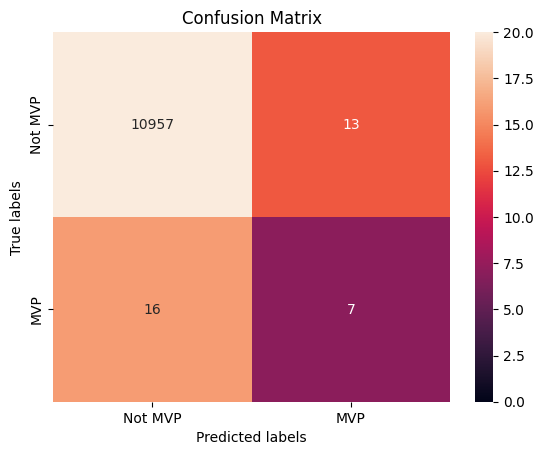

Scaledlogistic
[[10964     6]
 [   16     7]]


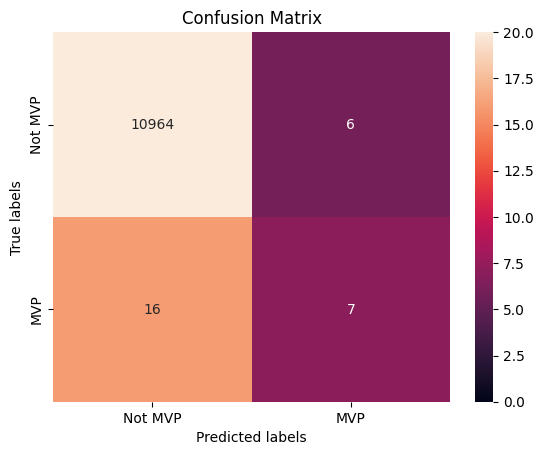

Scaledadaboost
[[10962     8]
 [   18     5]]


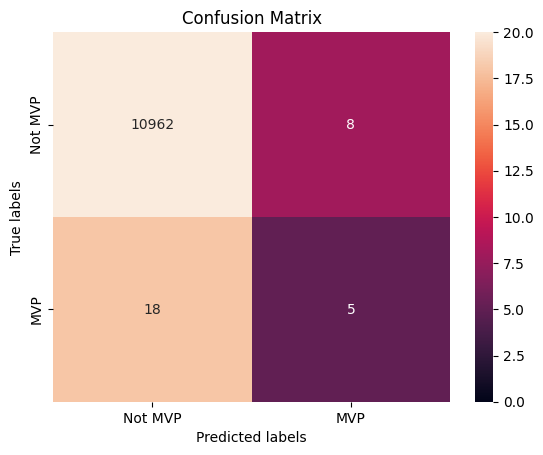

In [113]:
feat_select_models = score_models(X_selected_train, y_selected_train, X_selected_test, y_selected_test)

In [114]:
metrics = pd.DataFrame.from_dict(feat_select_models, 'index')[['train_f1_score', 'train_accuracy_score', 'test_f1_score', 'test_accuracy_score', 'tp', 'fp', 'fn', 'tn']]

In [115]:
metrics.sort_values(by='tp', ascending=False)

,train_f1_score,train_accuracy_score,test_f1_score,test_accuracy_score,tp,fp,fn,tn
logistic,0.734834,0.998164,0.715738,0.998090,8,6,15,10964
GradientBoostingClassifier,1.000000,1.000000,0.662130,0.997362,7,13,16,10957
ScaledGradientBoostingClassifier,1.000000,1.000000,0.662130,0.997362,7,13,16,10957
Scaledlogistic,0.718290,0.998164,0.693943,0.997999,7,6,16,10964
RandomForestClassifier,1.000000,1.000000,0.666211,0.998181,5,2,18,10968
adaboost,1.000000,1.000000,0.638297,0.997635,5,8,18,10962
ScaledRandomForestClassifier,1.000000,1.000000,0.655749,0.997999,5,4,18,10966
Scaledadaboost,1.000000,1.000000,0.638297,0.997635,5,8,18,10962
KNeighborsClassifier,0.822300,0.998878,0.632832,0.997999,4,3,19,10967
ScaledKNeighborsClassifier,0.772344,0.998470,0.606642,0.997999,3,2,20,10968


In [116]:
metrics = pd.DataFrame.from_dict(feat_select_models, 'index')[['train_f1_score', 'train_accuracy_score', 'test_f1_score', 'test_accuracy_score', 'tp', 'fp', 'fn', 'tn']]

In [117]:
metrics.sort_values(by='tp', ascending=False)

,train_f1_score,train_accuracy_score,test_f1_score,test_accuracy_score,tp,fp,fn,tn
logistic,0.734834,0.998164,0.715738,0.998090,8,6,15,10964
GradientBoostingClassifier,1.000000,1.000000,0.662130,0.997362,7,13,16,10957
ScaledGradientBoostingClassifier,1.000000,1.000000,0.662130,0.997362,7,13,16,10957
Scaledlogistic,0.718290,0.998164,0.693943,0.997999,7,6,16,10964
RandomForestClassifier,1.000000,1.000000,0.666211,0.998181,5,2,18,10968
adaboost,1.000000,1.000000,0.638297,0.997635,5,8,18,10962
ScaledRandomForestClassifier,1.000000,1.000000,0.655749,0.997999,5,4,18,10966
Scaledadaboost,1.000000,1.000000,0.638297,0.997635,5,8,18,10962
KNeighborsClassifier,0.822300,0.998878,0.632832,0.997999,4,3,19,10967
ScaledKNeighborsClassifier,0.772344,0.998470,0.606642,0.997999,3,2,20,10968


In [118]:
X_selected_train = train[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
y_selected_train = train['was_mvp']

In [119]:
X_selected_test = test[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
y_selected_test = test['was_mvp']

RandomForestClassifier
[[10968     2]
 [   19     4]]


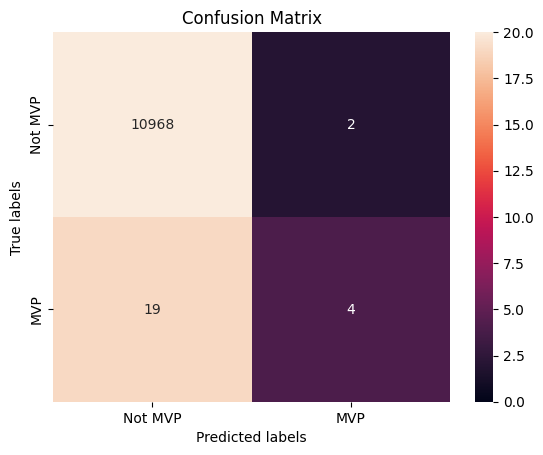

KNeighborsClassifier
[[10969     1]
 [   21     2]]


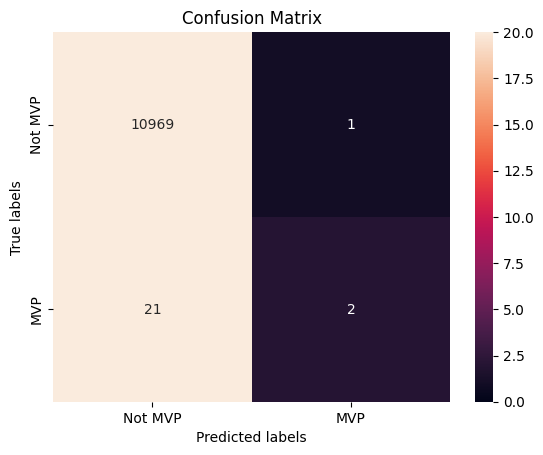

GradientBoostingClassifier
[[10950    20]
 [   12    11]]


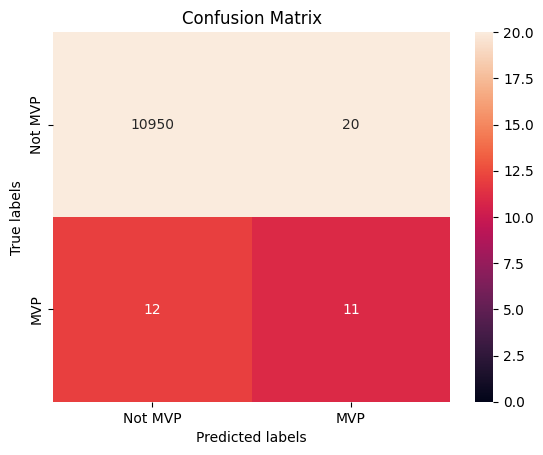

logistic
[[10965     5]
 [   15     8]]


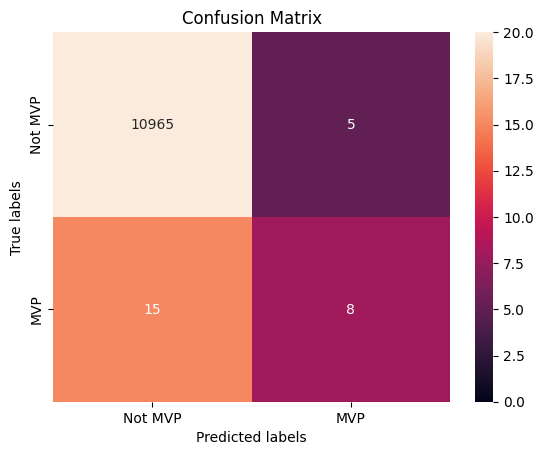

adaboost
[[10957    13]
 [   20     3]]


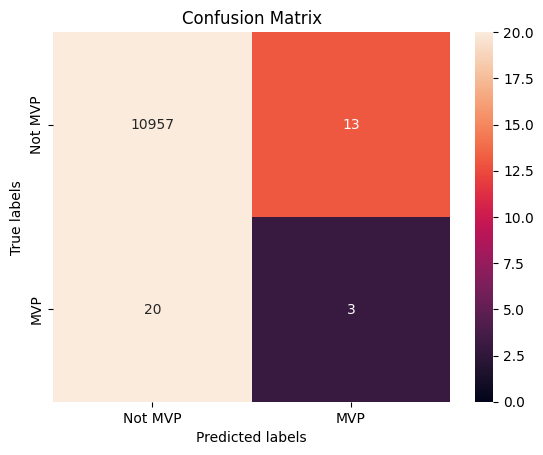

ScaledRandomForestClassifier
[[10969     1]
 [   21     2]]


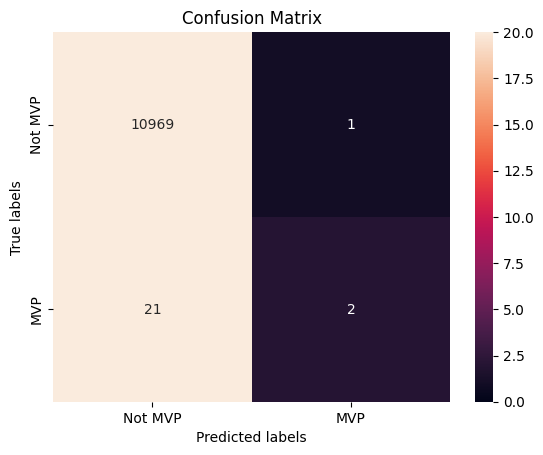

ScaledKNeighborsClassifier
[[10966     4]
 [   22     1]]


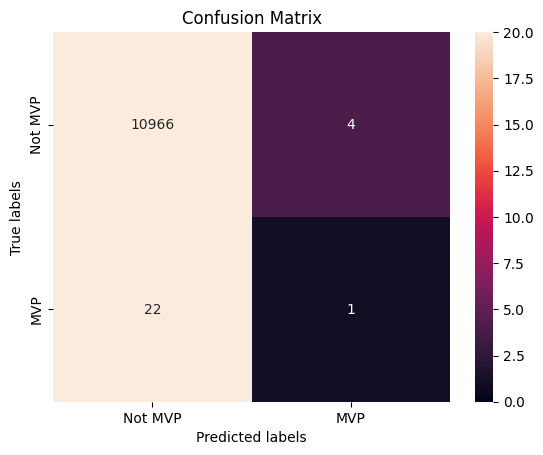

ScaledGradientBoostingClassifier
[[10950    20]
 [   12    11]]


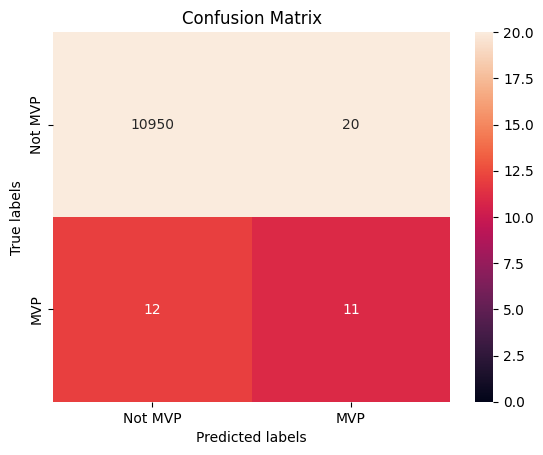

Scaledlogistic
[[10965     5]
 [   15     8]]


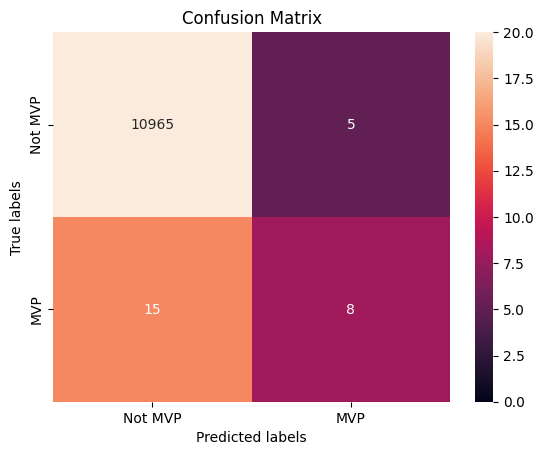

Scaledadaboost
[[10957    13]
 [   20     3]]


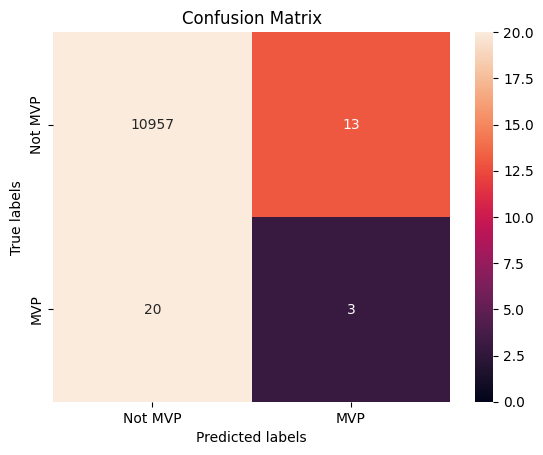

In [120]:
hand_select_models = score_models(X_selected_train, y_selected_train, X_selected_test, y_selected_test)

In [121]:
metrics = pd.DataFrame.from_dict(hand_select_models, 'index')[['train_f1_score', 'train_accuracy_score', 'test_f1_score', 'test_accuracy_score', 'tp', 'fp', 'fn', 'tn']]

In [122]:
metrics.sort_values(by='tp', ascending=False)

,train_f1_score,train_accuracy_score,test_f1_score,test_accuracy_score,tp,fp,fn,tn
GradientBoostingClassifier,0.911535,0.999082,0.702974,0.997089,11,20,12,10950
ScaledGradientBoostingClassifier,0.911535,0.999082,0.702974,0.997089,11,20,12,10950
logistic,0.749591,0.998368,0.721767,0.998181,8,5,15,10965
Scaledlogistic,0.772344,0.998470,0.721767,0.998181,8,5,15,10965
RandomForestClassifier,1.000000,1.000000,0.637453,0.998090,4,2,19,10968
adaboost,1.000000,1.000000,0.576171,0.996998,3,13,20,10957
Scaledadaboost,1.000000,1.000000,0.576171,0.996998,3,13,20,10957
KNeighborsClassifier,0.653387,0.998164,0.576422,0.997999,2,1,21,10969
ScaledRandomForestClassifier,1.000000,1.000000,0.576422,0.997999,2,1,21,10969
ScaledKNeighborsClassifier,0.713877,0.998368,0.535122,0.997635,1,4,22,10966


# Validating The Model

Let's validate the model by using data from 2019-2021.
Our models will output the predicted probability that the player is the MVP

In [160]:
df_2019 = pd.read_csv('../data/2019stats.csv')
df_2019_advanced = pd.read_csv('../data/2019advancedstats.csv')
l = [column for column in df_2019.columns if column in df_2019_advanced.columns]
l.remove('Player')
df_2019_advanced = df_2019_advanced.drop(columns = l)
df_2019['Player'] = df_2019['Player'].str.split('\\').str[0]
df_2019 = pd.merge(df_2019, df_2019_advanced, on='Player', how="inner")
df_2019.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2019 = per_game(df_2019, per_game_cols)
X = df_2019[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()

results_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict(X)
proba_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict_proba(X).tolist()


mvp_log_probs = []
mvp_rf_probs = []
mvp_gb_probs = []
for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])
    
for prob in proba_gb:
    mvp_gb_probs.append(prob[1])
# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2019['results_scaled_log'] = results_scaled_log
df_2019['results_RF'] = results_RF
df_2019['proba_scaled_log'] = mvp_log_probs
df_2019['proba_RF'] = mvp_rf_probs

df_2019['proba_gb'] = mvp_gb_probs
df_2019['results_gb'] = results_gb

## 2019 Prediction

In [163]:
df_2019.sort_values(by='proba_scaled_log', ascending=False)[['Player', 'proba_scaled_log', 'proba_RF', 'proba_gb']].head(10)

,Player,proba_scaled_log,proba_RF,proba_gb
12,Giannis Antetokounmpo,0.346536,0.23,0.015201
438,James Harden,0.074654,0.14,0.000088
309,Luka Dončić,0.042854,0.05,0.000024
530,LeBron James,0.040739,0.05,0.000024
557,Nikola Jokić,0.015166,0.00,0.000002
616,Damian Lillard,0.012857,0.00,0.000006
392,Rudy Gobert,0.010369,0.00,0.000001
282,Anthony Davis,0.009496,0.03,0.000149
834,Domantas Sabonis,0.006481,0.00,0.000002
613,Kawhi Leonard,0.004275,0.02,0.000024


## 2019 Winner

<img src="https://www.gannett-cdn.com/presto/2019/06/25/USAT/73e62a7e-f112-453b-858c-29c527c1bd94-2019-06-24_Giannis.jpg?crop=4096,3059,x425,y221"  width="900" height="600" class="center">


In [123]:
df_2020 = pd.read_csv('../data/2020stats.csv')
df_2020_advanced = pd.read_csv('../data/2020advancedstats.csv')
l = [column for column in df_2020.columns if column in df_2020_advanced.columns]
l.remove('Player')
df_2020_advanced = df_2020_advanced.drop(columns = l)
df_2020['Player'] = df_2020['Player'].str.split('\\').str[0]
df_2020 = pd.merge(df_2020, df_2020_advanced, on='Player', how="inner")
df_2020.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'Unnamed: 19', 'OWS', 'DWS', 'WS', 'WS/48',
       'Unnamed: 24', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Player-additional'],
      dtype='object')

In [124]:
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2020 = per_game(df_2020, per_game_cols)

In [125]:
X = df_2020[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]

In [126]:
results_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)


In [127]:
df_2020['results_scaled_log'] = results_scaled_log
df_2020['results_RF'] = results_RF

In [128]:
df_2020[df_2020['results_RF'] == 1]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,BLKPG,TOVPG,PFPG,FGAPG,FGPG,FTPG,FTAPG,MPPG,results_scaled_log,results_RF


In [164]:
df_2020 = pd.read_csv('../data/2020stats.csv')
df_2020_advanced = pd.read_csv('../data/2020advancedstats.csv')
l = [column for column in df_2020.columns if column in df_2020_advanced.columns]
l.remove('Player')
df_2020_advanced = df_2020_advanced.drop(columns = l)
df_2020['Player'] = df_2020['Player'].str.split('\\').str[0]
df_2020 = pd.merge(df_2020, df_2020_advanced, on='Player', how="inner")
df_2020.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2020 = per_game(df_2020, per_game_cols)
X = df_2020[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()
results_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict(X)
proba_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict_proba(X).tolist()


mvp_log_probs = []
mvp_rf_probs = []
mvp_gb_probs = []

for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])

for prob in proba_gb:
    mvp_gb_probs.append(prob[1])
    
# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2020['results_scaled_log'] = results_scaled_log
df_2020['results_RF'] = results_RF
df_2020['proba_scaled_log'] = mvp_log_probs
df_2020['proba_RF'] = mvp_rf_probs
df_2020['proba_gb'] = mvp_gb_probs
df_2020['results_gb'] = results_gb

## 2020 Prediction

In [165]:
df_2020.sort_values(by='proba_scaled_log', ascending=False)[['Player', 'proba_scaled_log', 'proba_RF', 'proba_gb']].head(10)

,Player,proba_scaled_log,proba_RF,proba_gb
559,Nikola Jokić,0.613426,0.48,1.000000
35,Giannis Antetokounmpo,0.081400,0.13,0.000024
425,James Harden,0.015027,0.05,0.000006
286,Luka Dončić,0.013429,0.01,0.000006
876,Julius Randle,0.012255,0.00,0.000002
366,Rudy Gobert,0.011006,0.00,0.000001
419,James Harden,0.009977,0.04,0.000006
310,Joel Embiid,0.009609,0.03,0.000006
427,James Harden,0.009274,0.05,0.000005
933,Domantas Sabonis,0.006281,0.00,0.000002


## 2020 Winner

<img src="https://cdn.vox-cdn.com/thumbor/ojdxX9FeKDMKxARCcX9Lg3DqHzI=/0x0:3616x2411/1200x800/filters:focal(1519x917:2097x1495)/cdn.vox-cdn.com/uploads/chorus_image/image/69528805/1233401948.0.jpg"  width="900" height="600" class="center">


In [168]:
df_2021 = pd.read_csv('../data/2021stats.csv')
df_2021_advanced = pd.read_csv('../data/2021advancedstats.csv')
l = [column for column in df_2021.columns if column in df_2021_advanced.columns]
l.remove('Player')
df_2021_advanced = df_2021_advanced.drop(columns = l)
df_2021['Player'] = df_2021['Player'].str.split('\\').str[0]
df_2021 = pd.merge(df_2021, df_2021_advanced, on='Player', how="inner")
df_2021.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2021 = per_game(df_2021, per_game_cols)
X = df_2021[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()
results_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict(X)
proba_gb = hand_select_models['GradientBoostingClassifier']['fitted_model'].predict_proba(X).tolist()

mvp_log_probs = []
mvp_rf_probs = []
mvp_gb_probs = []

for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])

for prob in proba_gb:
    mvp_gb_probs.append(prob[1])
    

# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2021['results_scaled_log'] = results_scaled_log
df_2021['results_RF'] = results_RF
df_2021['proba_scaled_log'] = mvp_log_probs
df_2021['proba_RF'] = mvp_rf_probs
df_2021['proba_gb'] = mvp_gb_probs
df_2021['results_gb'] = results_gb

## 2021 Prediction

In [169]:
df_2021[df_2021['results_RF'] == 1]
df_2021.sort_values(by='proba_RF', ascending=False)[['Player', 'proba_scaled_log', 'proba_RF', 'proba_gb']].head(10)

,Player,proba_scaled_log,proba_RF,proba_gb
715,Nikola Jokić,0.854658,0.59,1.000000
27,Giannis Antetokounmpo,0.301008,0.33,0.654075
344,Joel Embiid,0.127633,0.10,0.000024
494,James Harden,0.000480,0.08,0.000002
493,James Harden,0.000833,0.07,0.000002
492,James Harden,0.004436,0.07,0.000002
292,Luka Dončić,0.022276,0.05,0.000024
452,Shai Gilgeous-Alexander,0.000130,0.04,0.000002
455,Rudy Gobert,0.027269,0.04,0.000354
668,LeBron James,0.007047,0.03,0.000005


## 2021 Winner

<img src="https://pbs.twimg.com/media/E3ZZ2vIXoAkqKXj?format=jpg&name=900x900"  width="900" height="600" class="center">



In [133]:
df_2022 = pd.read_csv('../data/2022stats.csv')
df_2022_advanced = pd.read_csv('../data/2022advancedstats.csv')
l = [column for column in df_2022.columns if column in df_2022_advanced.columns]
l.remove('Player')
df_2022_advanced = df_2022_advanced.drop(columns = l)
df_2022['Player'] = df_2022['Player'].str.split('\\').str[0]
df_2022 = pd.merge(df_2022, df_2022_advanced, on='Player', how="inner")
df_2022.columns
per_game_cols = ['PTS', 'AST', 'ORB', 'DRB', 'TRB', 'STL', 'BLK', 'TOV', 'PF', 'FGA', 'FG', 'FT', 'FTA', 'MP']
df_2022 = per_game(df_2022, per_game_cols)
X = df_2022[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]
results_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict(X)
results_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict(X)
proba_scaled_log = hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist()
proba_RF = hand_select_models['RandomForestClassifier']['fitted_model'].predict_proba(X).tolist()
mvp_log_probs = []
mvp_rf_probs = []
for prob in proba_scaled_log:
    #print(prob[1])
    mvp_log_probs.append(prob[1])
for prob in proba_RF:
    mvp_rf_probs.append(prob[1])
# print(hand_select_models['Scaledlogistic']['fitted_model'].predict_proba(X).tolist())
# print(proba_RF)
df_2022['results_scaled_log'] = results_scaled_log
df_2022['results_RF'] = results_RF
df_2022['proba_scaled_log'] = mvp_log_probs
df_2022['proba_RF'] = mvp_rf_probs

In [134]:
df_2022.sort_values(by='proba_RF', ascending=False)[['Player', 'proba_scaled_log', 'proba_RF']].head(10)

,Player,proba_scaled_log,proba_RF
114,Luka Dončić,0.018566,0.16
130,Joel Embiid,0.001721,0.13
227,Nikola Jokić,0.023838,0.13
100,Anthony Davis,0.001420,0.10
10,Giannis Antetokounmpo,0.003486,0.10
432,Jayson Tatum,0.001003,0.03
98,Stephen Curry,0.000809,0.02
151,Shai Gilgeous-Alexander,0.000287,0.02
124,Kevin Durant,0.001194,0.02
174,James Harden,0.000447,0.02


# Creating API and Web Scraping

Using fastAPI and BeautifulSoup

In [ ]:
joblib.dump(hand_select_models['RandomForestClassifier']['fitted_model'], "mvp_random_forest.joblib")

In [ ]:
joblib.dump(hand_select_models['Scaledlogistic']['fitted_model'], "mvp_scaled_log.joblib")

In [170]:
joblib.dump(hand_select_models['GradientBoostingClassifier']['fitted_model'], "mvp_gb.joblib")

['mvp_gb.joblib']

In [149]:
def get_data() -> pd.DataFrame:
    """
    This function gets data from basketball reference and returns it as a data frame in the form of 
    Player Team GP	PPG	DRPG APG FG	WS USG% VORP BPM
    :return df: A data frame in the form of Player Team GP	PPG	DRPG APG FG	WS USG% VORP BPM
    """
    URL = "https://www.basketball-reference.com/leagues/NBA_2023_per_game.html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    stats_table = soup.find('table', {'id': 'per_game_stats'})
    player_stats = []
    rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
    for row in rows:
            player_stats.append({
            'Player': row.find('td', {'data-stat': 'player'}).text, # ['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']
            'Team': row.find('td', {'data-stat': 'team_id'}).text,
            'PTSPG': row.find('td', {'data-stat': 'pts_per_g'}).text,
            'ASTPG': row.find('td', {'data-stat': 'ast_per_g'}).text,
            'BLKPG': row.find('td', {'data-stat': 'blk_per_g'}).text,
            'DRBPG': row.find('td', {'data-stat': 'drb_per_g'}).text,
            'FGPG': row.find('td', {'data-stat': 'fg_per_g'}).text,
            })
        
    stats_df= pd.DataFrame(player_stats)

    URL = "https://www.basketball-reference.com/leagues/NBA_2023_advanced.html"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    stats_table = soup.find('table', {'id': 'advanced_stats'})
    rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
    player_stats = []
    for row in rows:
        player_stats.append({
        'Player': row.find('td', {'data-stat': 'player'}).text,
        'Team': row.find('td', {'data-stat': 'team_id'}).text,
        'WS': row.find('td', {'data-stat': 'ws'}).text,
        'USG%': row.find('td', {'data-stat': 'usg_pct'}).text,
        'VORP': row.find('td', {'data-stat': 'vorp'}).text,
        'BPM': row.find('td', {'data-stat': 'bpm'}).text,
        })
        

    adv_df = pd.DataFrame(player_stats)

    df = pd.merge(stats_df, adv_df, on=['Player', 'Team'], how="inner")
    return df 

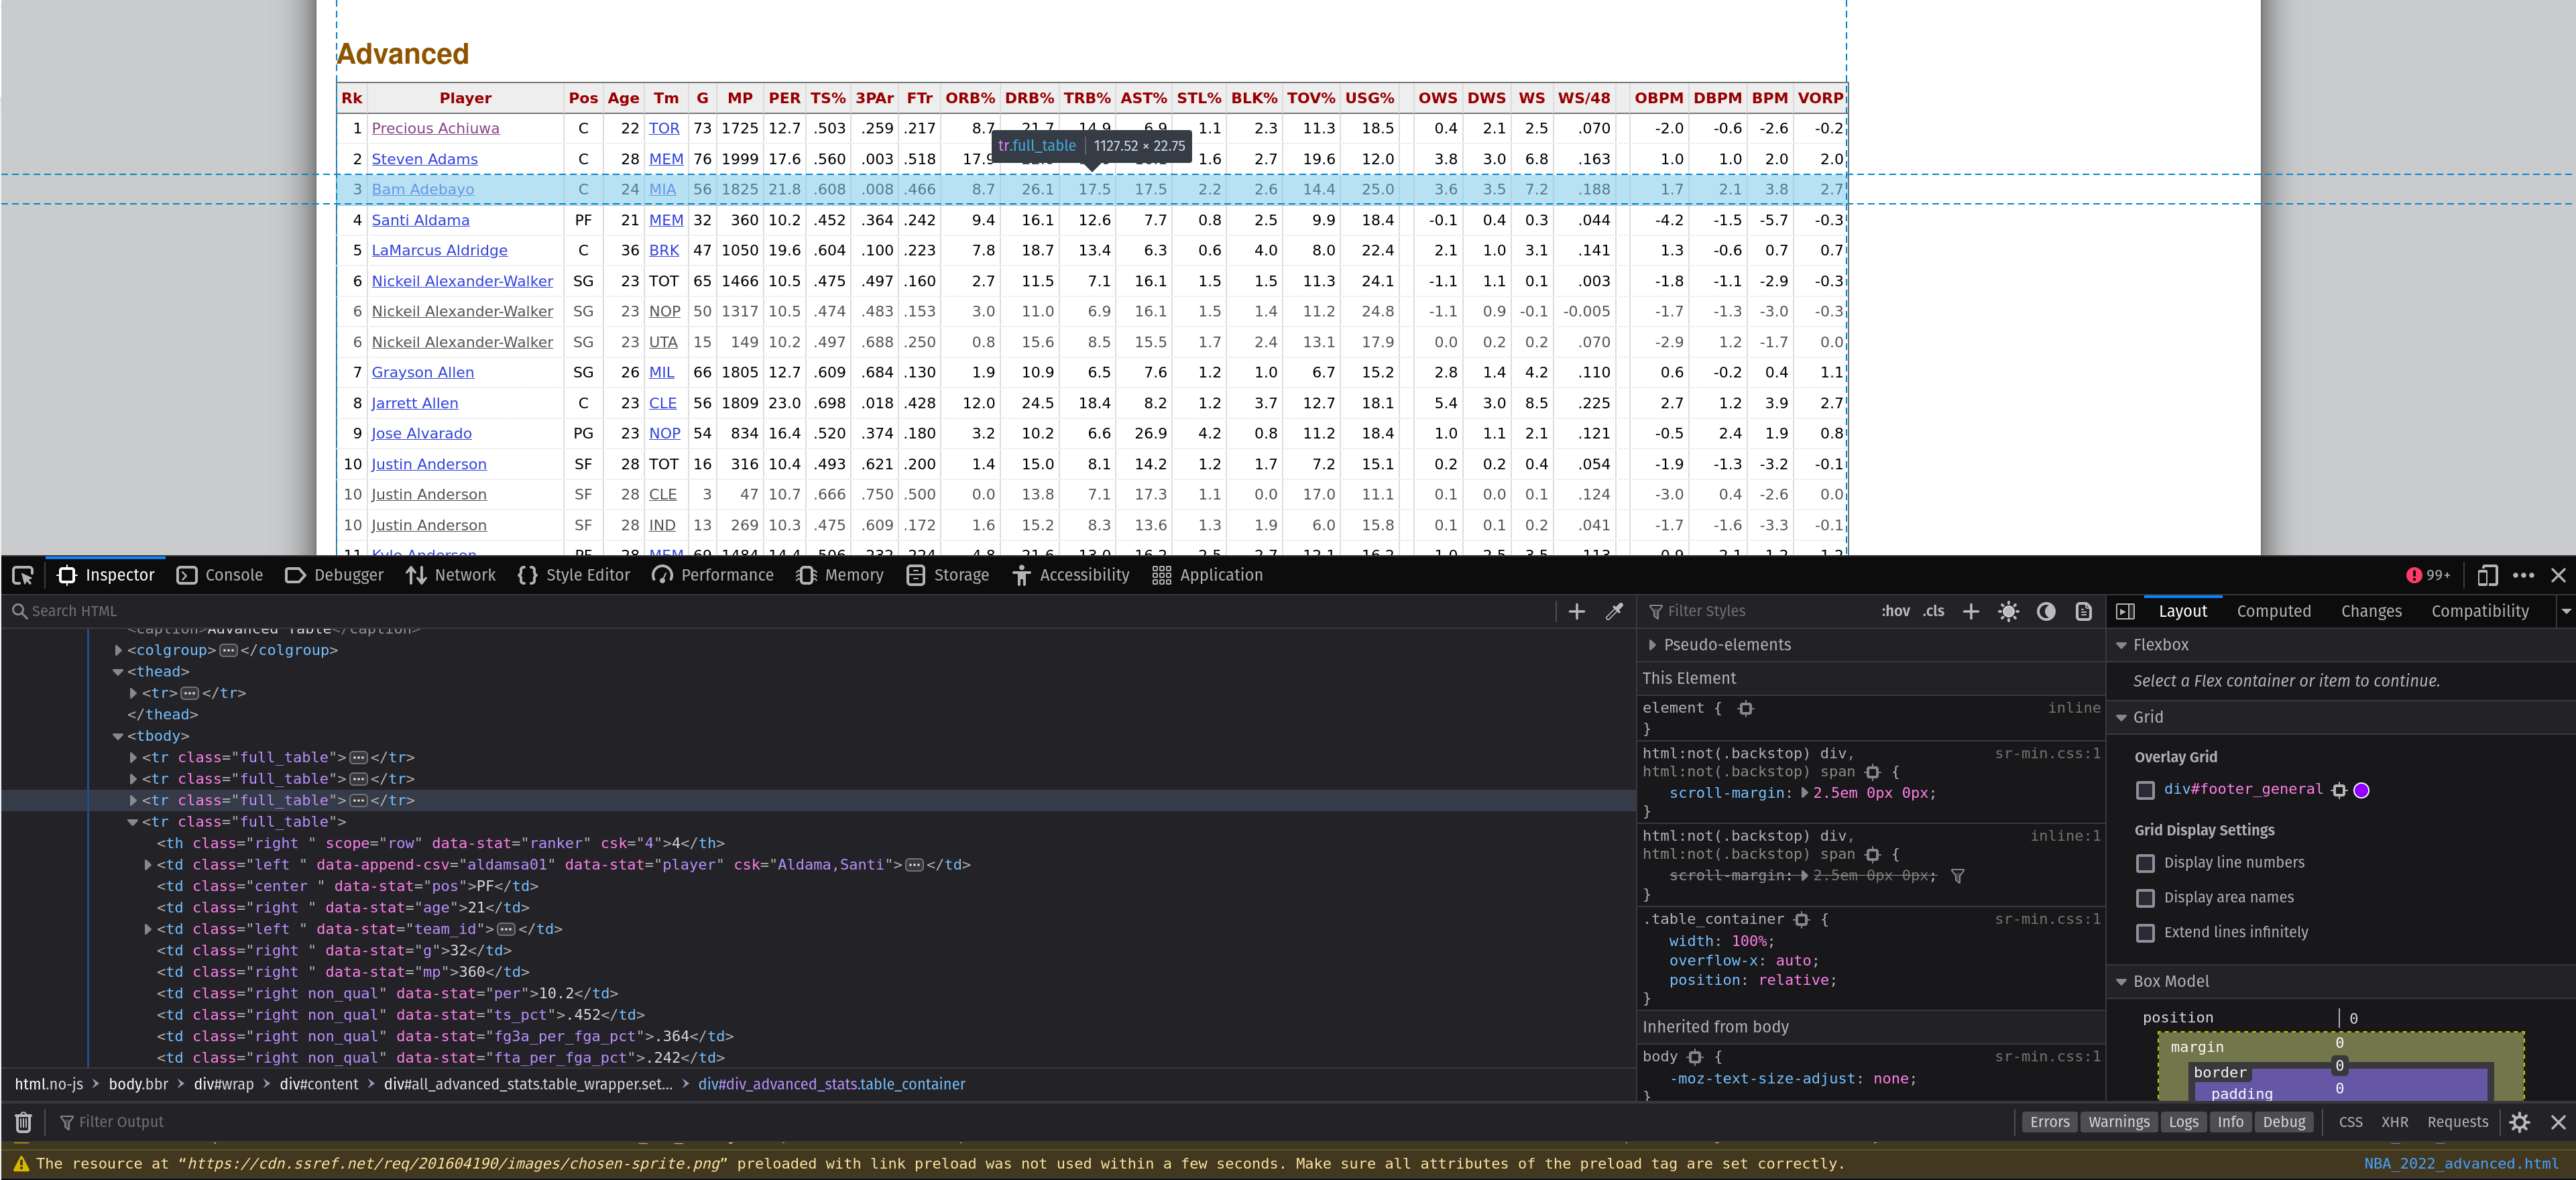

In [151]:
URL = "https://www.basketball-reference.com/leagues/NBA_2023_per_game.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

stats_table = soup.find('table', {'id': 'per_game_stats'})
player_stats = []
rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
for row in rows:
        player_stats.append({
        'Player': row.find('td', {'data-stat': 'player'}).text, # ['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']
        'Team': row.find('td', {'data-stat': 'team_id'}).text,
        'PTSPG': row.find('td', {'data-stat': 'pts_per_g'}).text,
        'ASTPG': row.find('td', {'data-stat': 'ast_per_g'}).text,
        'BLKPG': row.find('td', {'data-stat': 'blk_per_g'}).text,
        'DRBPG': row.find('td', {'data-stat': 'drb_per_g'}).text,
        'FGPG': row.find('td', {'data-stat': 'fg_per_g'}).text,
        })

stats_df= pd.DataFrame(player_stats)

In [152]:
stats_df

,Player,Team,PTSPG,ASTPG,BLKPG,DRBPG,FGPG
0,Precious Achiuwa,TOR,8.8,1.0,0.7,4.0,3.1
1,Steven Adams,MEM,8.6,2.3,1.1,6.5,3.7
2,Bam Adebayo,MIA,21.6,3.0,0.8,7.3,8.7
3,Ochai Agbaji,UTA,4.1,0.4,0.1,1.1,1.6
4,Santi Aldama,MEM,9.3,1.2,0.8,3.6,3.3
...,...,...,...,...,...,...,...
493,Delon Wright,WAS,6.7,3.8,0.4,1.9,2.3
494,McKinley Wright IV,DAL,1.9,1.4,0.2,0.9,0.7
495,Thaddeus Young,TOR,4.9,1.6,0.1,2.0,2.2
496,Trae Young,ATL,27.0,9.9,0.1,2.2,8.5


In [ ]:

URL = "https://www.basketball-reference.com/leagues/NBA_2023_advanced.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')

stats_table = soup.find('table', {'id': 'advanced_stats'})
rows = stats_table.tbody.find_all('tr', attrs={'class': 'full_table'})
player_stats = []
for row in rows:
    player_stats.append({
    'Player': row.find('td', {'data-stat': 'player'}).text,
    'Team': row.find('td', {'data-stat': 'team_id'}).text,
    'WS': row.find('td', {'data-stat': 'ws'}).text,
    'USG%': row.find('td', {'data-stat': 'usg_pct'}).text,
    'VORP': row.find('td', {'data-stat': 'vorp'}).text,
    'BPM': row.find('td', {'data-stat': 'bpm'}).text,
    })

In [ ]:
df = pd.merge(stats_df, adv_df, on=['Player', 'Team'], how="inner")

In [150]:
get_data()

,Player,Team,PTSPG,ASTPG,BLKPG,DRBPG,FGPG,WS,USG%,VORP,BPM
0,Precious Achiuwa,TOR,8.8,1.0,0.7,4.0,3.1,0.7,20.5,-0.1,-3.2
1,Steven Adams,MEM,8.6,2.3,1.1,6.5,3.7,3.5,14.3,0.8,0.8
2,Bam Adebayo,MIA,21.4,3.0,0.8,7.2,8.6,4.4,26.3,1.3,1.4
3,Ochai Agbaji,UTA,3.9,0.4,0.2,1.0,1.5,0.5,11.7,-0.1,-3.0
4,Santi Aldama,MEM,9.3,1.2,0.8,3.7,3.3,3.1,15.4,0.9,1.7
...,...,...,...,...,...,...,...,...,...,...,...
492,Delon Wright,WAS,6.5,3.7,0.4,1.9,2.2,1.2,13.8,0.7,5.7
493,McKinley Wright IV,DAL,1.9,1.4,0.2,0.9,0.7,0.1,12.3,-0.1,-4.4
494,Thaddeus Young,TOR,4.9,1.6,0.1,2.0,2.2,1.5,12.9,0.3,0.2
495,Trae Young,ATL,27.1,9.8,0.1,2.2,8.5,3.6,33.3,1.8,2.7


In [ ]:
@app.get('/predict', tags=["predictions"])
async def get_prediction():

    stats_df = get_data()
    players = stats_df['Player']
    teams = stats_df['Team']
    X = stats_df.drop(columns=['Player', 'Team'])[['PTSPG', 'ASTPG', 'WS', 'BLKPG', 'DRBPG', 'VORP', 'BPM', 'USG%', 'FGPG']]

    proba_scaled_log = scaled_log_model.predict_proba(X).tolist()
    proba_RF = rf_model.predict_proba(X).tolist()
    proba_gb = gb_model.predict_proba(X).tolist()
    mvp_log_probs = []
    mvp_rf_probs = []
    mvp_gb_probs = []
    for prob in proba_scaled_log:
        mvp_log_probs.append(prob[1])
    for prob in proba_RF:
        mvp_rf_probs.append(prob[1])

    for prob in proba_gb:
        mvp_gb_probs.append(prob[1])

    stats_df['proba_scaled_log'] = mvp_log_probs
    stats_df['proba_RF'] = mvp_rf_probs
    stats_df['proba_gb'] = mvp_gb_probs
    result_df = stats_df.sort_values(by='proba_scaled_log', ascending=False)[['Player', 'proba_scaled_log', 'proba_RF', 'proba_gb']].head(10)
    return result_df.to_dict()


# Current Season Prediction

In [179]:
import requests
import json
x = requests.get('http://127.0.0.1:8000/predict')




In [204]:
data = json.loads(x.text)
data

{'Player': {'231': 'Nikola Jokić',
  '115': 'Luka Dončić',
  '401': 'Domantas Sabonis',
  '132': 'Joel Embiid',
  '10': 'Giannis Antetokounmpo',
  '101': 'Anthony Davis',
  '432': 'Jayson Tatum',
  '126': 'Kevin Durant',
  '176': 'James Harden',
  '221': 'LeBron James'},
 'proba_scaled_log': {'231': 0.3310366900143975,
  '115': 0.06511833258065716,
  '401': 0.015003844762201086,
  '132': 0.008496866150031552,
  '10': 0.005737566839005053,
  '101': 0.003516007302202947,
  '432': 0.0030786547437529005,
  '126': 0.0030095909846824904,
  '176': 0.002828774915452109,
  '221': 0.002681686063604387},
 'proba_RF': {'231': 0.08,
  '115': 0.09,
  '401': 0.01,
  '132': 0.08,
  '10': 0.09,
  '101': 0.05,
  '432': 0.02,
  '126': 0.05,
  '176': 0.0,
  '221': 0.09},
 'proba_gb': {'231': 2.433260517511559e-05,
  '115': 2.433260517511559e-05,
  '401': 1.7591523193201166e-06,
  '132': 0.00011025498934533393,
  '10': 5.0163876156409545e-06,
  '101': 0.00014873606472039385,
  '432': 6.187378376688802e-06,

In [205]:
players = []
for player in data['Player'].values():
    players.append(player)

In [206]:
probs_rf = []
for prob in data['proba_RF'].values():
    probs_rf.append(prob)

In [207]:
probs_gb = []
for prob in data['proba_gb'].values():
    probs_gb.append(prob)

In [208]:
probs_log = []
for prob in data['proba_scaled_log'].values():
    probs_log.append(prob)

In [216]:
df = pd.DataFrame()

In [217]:
df['Player'] = players
df['proba_RF'] = probs_rf
df['proba_gb'] = probs_gb
df['proba_scaled_log'] = probs_log

In [220]:
df.sort_values(by='proba_scaled_log', ascending=False)[['Player', 'proba_scaled_log', 'proba_gb']]

,Player,proba_scaled_log,proba_gb
0,Nikola Jokić,0.331037,0.000024
1,Luka Dončić,0.065118,0.000024
2,Domantas Sabonis,0.015004,0.000002
3,Joel Embiid,0.008497,0.000110
4,Giannis Antetokounmpo,0.005738,0.000005
5,Anthony Davis,0.003516,0.000149
6,Jayson Tatum,0.003079,0.000006
7,Kevin Durant,0.003010,0.000006
8,James Harden,0.002829,0.000002
9,LeBron James,0.002682,0.000006


# Citations

- https://www.basketball-reference.com/
- äon intelligence (https://www.youtube.com/watch?v=Yan7y3N4V3c)